In [8]:
import heapq as h
import numpy as np

POISSON_PROCESS_NEW_REQUESTS_LAMBDA = 100
PARETO_PROCESS_NEW_FILE_SIZE_A = 1
PARETO_PROCESS_FILE_POPULARITY_A = 1
LOGNORMAL_PROCESS_ARRIVE_AT_QUEUE_MEAN = 0.5
LOGNORMAL_PROCESS_ARRIVE_AT_QUEUE_SIGMA = 0.4

TOTAL_NO_OF_FILES = 1000
INSTITUTIONAL_BANDWIDTH = 1000
ACCESS_LINK_BANDWIDTH = 15
TOTAL_TIME_TO_RUN = 1000
CACHE_CAPACITY = 10
CACHE_MAX_ALLOWED_FILE_SIZE = 10


class Files:
    def __init__(self):
        self.popularity = np.random.pareto(PARETO_PROCESS_FILE_POPULARITY_A,size=TOTAL_NO_OF_FILES)
        self.popularity = self.popularity/np.sum(self.popularity)
        self.size = np.random.pareto(PARETO_PROCESS_NEW_FILE_SIZE_A,size=TOTAL_NO_OF_FILES)



class Simulation_Q():
    def __init__(self):
        self.q = []
    
    def push(self, event_tuple:tuple):
        h.heappush(self.q,event_tuple)

    def pop(self):
        return h.heappop(self.q)[1]
        
class Cache():
    def __init__(self,
    all_files:Files,
    init_file_list=[]):

        self.capacity = CACHE_CAPACITY
        self.store = {}
        self.storage_left = CACHE_CAPACITY
        self.all_files = all_files
        self.__subclass_declarations__()
        for i in range(len(init_file_list)):
            if not self.add_file(init_file_list[i]):
                break
    
    def __subclass_declarations__(self):
        pass

    def file_present(self,file_index):
        if file_index in self.store:
            return True
        return False


    def add_file(self,file_index):
        if file_index not in self.store:
            if self.storage_left > self.all_files.size[file_index]:
                self.store[file_index] = self.all_files.size[file_index]
                self.storage_left -= self.all_files.size[file_index]
            else:
                return False
        return True


class LRU_File():
    def __init__(self,file_index,file_size):
        self.next = None
        self.prev = None
        self.id = file_index
        self.size = file_size
        self.hits = 0


class LRU_Cache(Cache):
    
    def __subclass_declarations__(self):
        self.lru_root = None
        self.lru_tail = None
        self.hit_counter = 0

    def file_present(self,file_index):
        if file_index in self.store:
            file = self.store[file_index]
            # self.hit_counter += 1
            if file.prev is not None and file.next is not None:
                file.prev.next = file.next
                file.next.prev = file.prev
                self.lru_tail.next = file
                file.prev = self.lru_tail   
                self.lru_tail = file
                self.lru_tail.next = None
            elif file.prev is None and file.next is not None:
                self.lru_root = file.next
                self.lru_root.prev = None
                self.lru_tail.next = file
                file.prev = self.lru_tail   
                self.lru_tail = file
                self.lru_tail.next = None
            file.hits += 1
            
            # print(file_index,'R',self.get_lru_list())
            return True
        return False


    def add_file(self,file_index):    
        if self.all_files.size[file_index] > CACHE_MAX_ALLOWED_FILE_SIZE or self.all_files.size[file_index] > CACHE_CAPACITY:
            return False  
        if file_index not in self.store:
            file = LRU_File(file_index,self.all_files.size[file_index]) 
            # if increment_counter:
            #     self.hit_counter += 1
            if self.storage_left > self.all_files.size[file_index]:

                if self.lru_root is None:
                    self.lru_root = file
                if self.lru_tail is None:
                    self.lru_tail = file
                else:
                    self.lru_tail.next = file
                    file.prev = self.lru_tail                    
                    self.lru_tail = file
                    self.lru_tail.next = None
                self.store[file.id] = file
                self.storage_left -= file.size
                file.hits += 1

            else:
                while(self.storage_left <= file.size):
                    if self.lru_root is None:
                        raise Exception('LRU Cache - Storage inconsistency')                       

                    file_to_discard = self.lru_root
                    self.lru_root = file_to_discard.next
                    if self.lru_root is None:
                        self.lru_tail = None
                    else:
                        self.lru_root.prev = None
                    del self.store[file_to_discard.id]
                    self.storage_left += file_to_discard.size
                self.add_file(file_index)

            # print(file_index,'W',self.get_lru_list(),file.size)  
        else:
            self.file_present(file_index)        
        
        return True
        

    def get_stored_file_list(self):
        file_list = []
        for key in self.store:
            file_list.append([self.store[key].id,self.store[key].hits])
        return file_list

    def get_lru_list(self):
        file_list = []
        node = self.lru_root
        while(node is not None):
            file_list.append(node.id)
            node = node.next
        return file_list


         



class Simulator_Env():
    def __init__(self, Files:Files, Cache:Cache, cache_init_files=[]):

        self.sim_q = Simulation_Q()
        self.files = Files
        self.cache = Cache
        self.fifo = []
        self.log = []
        self.req_count = 0
    
    def get_total_times_for_reqs(self):
        return(np.array(self.log)[:,0])

    def print_logs(self):
        for data in self.log:    
            e = data[3]
            path = []
            while(e is not None):
                path.insert(0,e.name)
                e = e.parent
            print('file name - ' + str(data[1]))    
            print('file size - ' + str(data[2]))
            print('total time - ' + str(data[0]))
            print(path)
            print(' ')


class Event:

    def __init__(self, sim: Simulator_Env, create_time: int, parent:object=None):
        self.sim = sim
        self.create_time = create_time
        self.process_time = create_time
        self.parent = parent
        self.name = 'Event'
        self.__enqueue__()

    def get_super_parent(self):
        node = self
        while(node.parent is not None):
            node = node.parent
        return node

    def __lt__(self,any):
        return True

    def __gt__(self,any):
        return True

    def __enqueue__(self):
        pass


    def process(self):
        pass


class E_get_new_reqs(Event):

    def __enqueue__(self):
        self.name = 'Get New Requests'
        self.sim.sim_q.push([self.process_time,self])

    def process(self):
        reqs_to_handle = np.random.poisson(POISSON_PROCESS_NEW_REQUESTS_LAMBDA)
        for i in range(int(reqs_to_handle)):
            E_new_req(self.sim, self.process_time)


class E_new_req(Event):
    def __enqueue__(self):
        self.name = 'New Request'
        self.sim.req_count += 1
        self.file_index = np.argmax(np.random.multinomial(1,self.sim.files.popularity))
        self.file_size = self.sim.files.size[self.file_index]        
        # self.process_time = self.create_time + (self.file_size/INSTITUTIONAL_BANDWIDTH)
        self.sim.sim_q.push([self.process_time,self])

    def process(self):
        if self.sim.cache.file_present(self.file_index):
            E_file_recieved(self.sim,self.process_time,self)
        else:
            E_arrive_at_queue(self.sim,self.process_time,self)


class E_file_recieved(Event):
    def __enqueue__(self):
        self.name = 'File recieved'
        initial_req = self.get_super_parent()
        file_size = self.sim.files.size[initial_req.file_index]
        self.process_time = self.create_time + (file_size/ INSTITUTIONAL_BANDWIDTH)
        self.sim.sim_q.push([self.process_time,self])

    def process(self):
        initial_req = self.get_super_parent()
        log_data = [self.process_time - initial_req.create_time, initial_req.file_index, initial_req.file_size,self]
        self.sim.log.append(log_data)


class E_arrive_at_queue(Event):
    def __enqueue__(self):
        self.name = 'Arrive at queue'
        self.process_time = self.create_time + np.random.lognormal(LOGNORMAL_PROCESS_ARRIVE_AT_QUEUE_MEAN,
                                                                    LOGNORMAL_PROCESS_ARRIVE_AT_QUEUE_SIGMA)
        
        self.sim.sim_q.push([self.process_time,self])

    def process(self):
        if len(self.sim.fifo):
            self.sim.fifo.append(self)
        else:
            E_depart_from_queue(self.sim,self.process_time,self)


class E_depart_from_queue(Event):
    def __enqueue__(self):
        self.name = 'Depart from queue'
        initial_req = self.get_super_parent()
        self.process_time = self.create_time + (initial_req.file_size/ACCESS_LINK_BANDWIDTH)
        self.sim.sim_q.push([self.process_time,self])

    def process(self):
        initial_req = self.get_super_parent()
        self.sim.cache.add_file(initial_req.file_index)
        E_file_recieved(self.sim,self.process_time,self)
        if len(self.sim.fifo):
            event = self.sim.fifo.pop(0)
            E_depart_from_queue(self.sim,self.process_time,event)




In [34]:
class MRU_Cache(Cache):
    
    def __subclass_declarations__(self):
        self.mru_root = None
        # self.lru_tail = None
        self.hit_counter = 0

    def file_present(self,file_index):
        if file_index in self.store:
            file = self.store[file_index]
            # self.hit_counter += 1

            if file.prev is not None:                
                file.prev.next = file.next
                if file.next is not None:
                    file.next.prev = file.prev

                file.next = self.mru_root
                self.mru_root.prev = file
                self.mru_root = file
                self.mru_root.prev = None
                
            file.hits += 1
            
            print(file_index,'R',self.get_mru_list())
            return True
        return False


    def add_file(self,file_index):    
        if self.all_files.size[file_index] > CACHE_MAX_ALLOWED_FILE_SIZE or self.all_files.size[file_index] > CACHE_CAPACITY:
            return False  
        if file_index not in self.store:
            file = LRU_File(file_index,self.all_files.size[file_index]) 
            # if increment_counter:
            #     self.hit_counter += 1
            if self.storage_left > self.all_files.size[file_index]:

                if self.mru_root is None:
                    self.mru_root = file
                else:
                    file.next = self.mru_root
                    self.mru_root.prev = file
                    self.mru_root = file
                    self.mru_root.prev = None
                self.store[file.id] = file
                self.storage_left -= file.size
                file.hits += 1

            else:
                while(self.storage_left <= file.size):
                    if self.mru_root is None:
                        raise Exception('LRU Cache - Storage inconsistency')                       

                    file_to_discard = self.mru_root
                    self.mru_root = file_to_discard.next
                    if self.mru_root is not None:
                        self.mru_root.prev = None
                    del self.store[file_to_discard.id]
                    self.storage_left += file_to_discard.size
                self.add_file(file_index)

            print(file_index,'W',self.get_mru_list(),file.size)  
        else:
            self.file_present(file_index)        
        
        return True



    def get_stored_file_list(self):
        file_list = []
        for key in self.store:
            file_list.append([self.store[key].id,self.store[key].hits])
        return file_list

    def get_mru_list(self):
        file_list = []
        node = self.mru_root
        while(node is not None):
            file_list.append(node.id)
            node = node.next
        return file_list

In [35]:
POISSON_PROCESS_NEW_REQUESTS_LAMBDA = 100
PARETO_PROCESS_NEW_FILE_SIZE_A = 2
PARETO_PROCESS_FILE_POPULARITY_A = 1
LOGNORMAL_PROCESS_ARRIVE_AT_QUEUE_MEAN = 0.5
LOGNORMAL_PROCESS_ARRIVE_AT_QUEUE_SIGMA = 0.4

TOTAL_NO_OF_FILES = 10000
INSTITUTIONAL_BANDWIDTH = 1000
ACCESS_LINK_BANDWIDTH = 15
TOTAL_TIME_TO_RUN = 10
CACHE_CAPACITY = 10
CACHE_MAX_ALLOWED_FILE_SIZE = 100


# initialize simulator environment
# np.random.seed(11)
files = Files()
cache = MRU_Cache(files)
# cache = Cache(files)

sim = Simulator_Env(files,cache)

#initialize new req events to be processed at every second
for i in range(TOTAL_TIME_TO_RUN):
    E_get_new_reqs(sim,i)


#Main simulator loop
while(len(sim.sim_q.q)):

    e = sim.sim_q.pop()
    e.process()
    
    

print(len(sim.log) == sim.req_count)


np.mean(sim.get_total_times_for_reqs())

5578 W [5578] 0.06603990245503955
7607 W [7607, 5578] 0.0839732127327193
4068 W [4068, 7607, 5578] 0.025408031930066244
1535 W [1535, 4068, 7607, 5578] 0.14092787636555215
2690 W [2690, 1535, 4068, 7607, 5578] 0.07339068967936568
9947 W [9947, 2690, 1535, 4068, 7607, 5578] 2.1510822451404223
1535 R [1535, 9947, 2690, 4068, 7607, 5578]
6684 W [6684, 1535, 9947, 2690, 4068, 7607, 5578] 3.074674174916079
1535 R [1535, 6684, 9947, 2690, 4068, 7607, 5578]
6684 R [6684, 1535, 9947, 2690, 4068, 7607, 5578]
6684 R [6684, 1535, 9947, 2690, 4068, 7607, 5578]
6684 R [6684, 1535, 9947, 2690, 4068, 7607, 5578]
6684 R [6684, 1535, 9947, 2690, 4068, 7607, 5578]
6684 R [6684, 1535, 9947, 2690, 4068, 7607, 5578]
5578 R [5578, 6684, 1535, 9947, 2690, 4068, 7607]
6684 R [6684, 5578, 1535, 9947, 2690, 4068, 7607]
6684 R [6684, 5578, 1535, 9947, 2690, 4068, 7607]
1535 R [1535, 6684, 5578, 9947, 2690, 4068, 7607]
6684 R [6684, 1535, 5578, 9947, 2690, 4068, 7607]
1535 R [1535, 6684, 5578, 9947, 2690, 4068, 7

1.4290177711265815

In [27]:
cache.get_stored_file_list()

[[9219, 1],
 [1082, 1],
 [7803, 1],
 [8603, 1],
 [967, 1],
 [839, 1],
 [6987, 1],
 [327, 1],
 [6477, 1],
 [4943, 1]]

In [4]:
import seaborn as sns
np.mean(sim.get_total_times_for_reqs())

1.3147954452601427

In [5]:
def sigmoid(x):

    return(1/(1 + np.exp(-x)))

sigmoid(80)

1.0

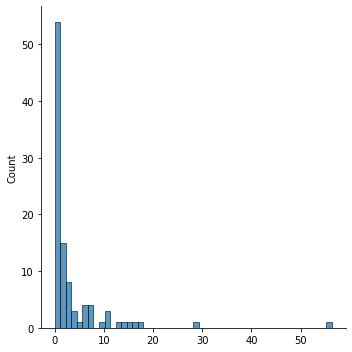

In [6]:
import seaborn as sns
sns.displot(np.random.pareto(1,size=100))

In [7]:
np.mean(np.random.pareto(2,size=1000))

0.9808676814781222